# Processing molecular dynamics trajectories #

In this experiment we showcase how the tools from Riemannian geometry help us understand protein data sets. In particular, we want to show how 
* having geodesics under a suitable Riemannian metric can preserve important features of the data
* having a suitable notion of distance is useful in computing a natural mean of the data
* having a logarithmic mappings is useful in dimension reduction and having an exponential mapping is useful for visualizing the subspace

## Load data ##

In [42]:
import networkx as nx
%load_ext autoreload
%autoreload 2

import torch
import os
import matplotlib.pyplot as plt
    
from src.manifolds.pointcloud import PointCloud
from src.manifolds.geodesics_dataset import prepare_data, TrajGeodesicsDataset

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.autolayout': True})

seed = 42
batch_size = 4

struct = 1
results_folder = os.path.join(os.getcwd(), "results")
data_folder = os.path.join('..', "data", "molecular_dynamics")

ca_pos = prepare_data(struct, data_folder)
dataset = GeodesicsDataset(ca_pos)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Shape of full data: (102, 3341, 3) (L x N x D)
Shape of CA data: torch.Size([102, 214, 3]) (L x N x D)
Number of CA atoms: 214
Number of timesteps: 102
CA atom data dimensionality: 3 (should be 3 for 3D data)
(102, 102)


In [43]:
dir(dataset)

['__add__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_is_protocol',
 'all_geodesics',
 'atom_dim',
 'ca_pos',
 'corrections',
 'graph',
 'manifold',
 'n_atoms',
 'n_pointclouds',
 'pairwise_distances',
 'pw_dist']

In [49]:
dataset.manifold.alpha

1.0

Differences between distances between timesteps: [ 3.26199460e+00  1.08576751e+00  5.06711483e-01  5.64826965e-01
  5.40316105e-01  4.20275211e-01  7.03000069e-01  5.52995205e-01
  6.73943520e-01  3.42063904e-01  3.07811737e-01  3.62536430e-01
  4.12500381e-01  3.55425835e-01  3.97149086e-01  1.15608215e-01
  4.64001656e-01  5.09585381e-01  3.53757858e-01  3.50650787e-01
  4.56103325e-01  2.50626564e-01  4.87276077e-01  5.31067848e-01
  2.53538132e-01  3.95834923e-01  3.32793236e-01  3.78846169e-01
  2.93709755e-01  4.28792000e-01  3.36271286e-01  5.17339706e-01
  4.04176712e-01  3.79007339e-01  5.72166443e-01  3.02631378e-01
  3.76951218e-01  6.11665726e-01  3.62661362e-01  3.89579773e-01
  5.71298599e-01  3.31996918e-01  3.09492111e-01  5.85805893e-01
  1.90639496e-01  6.54356003e-01  3.68118286e-01  7.22003937e-01
  2.87672043e-01  4.91598129e-01  5.12086868e-01  8.00891876e-01
  2.37516403e-01  2.32788086e-01  4.87293243e-01  3.58665466e-01
  5.44242859e-01  3.01580429e-01  2.52885

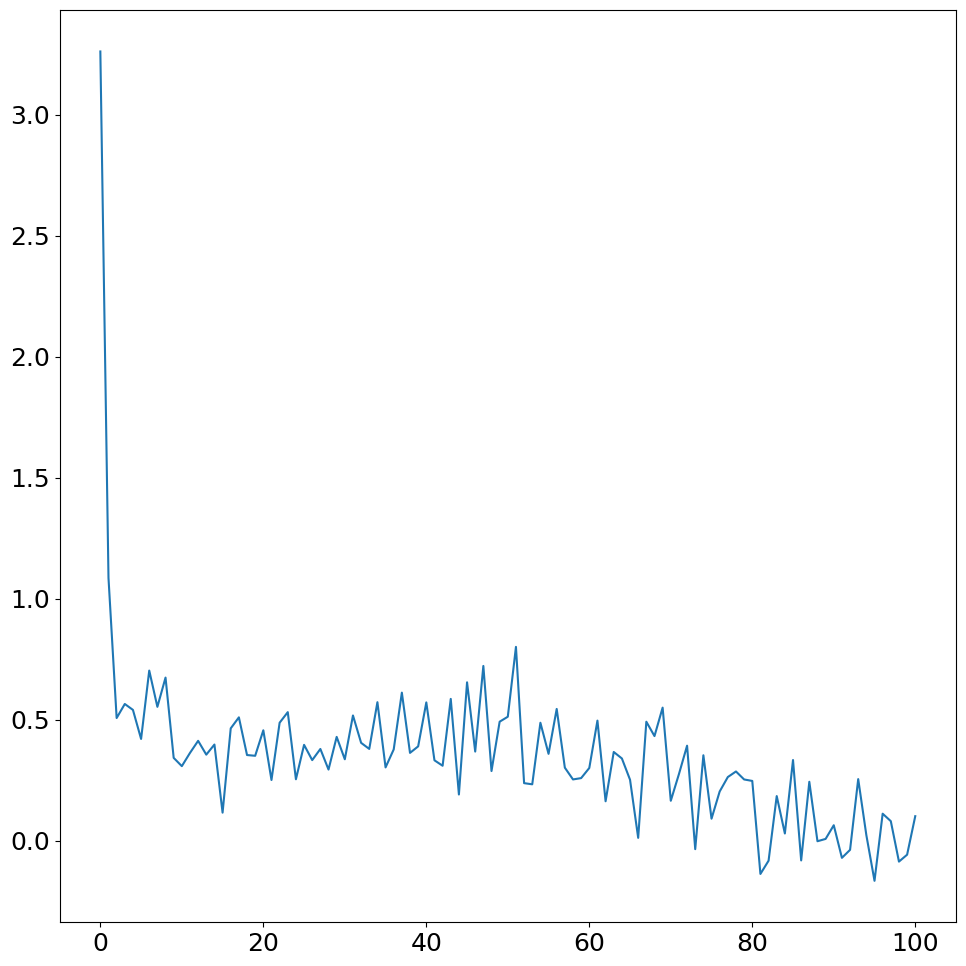

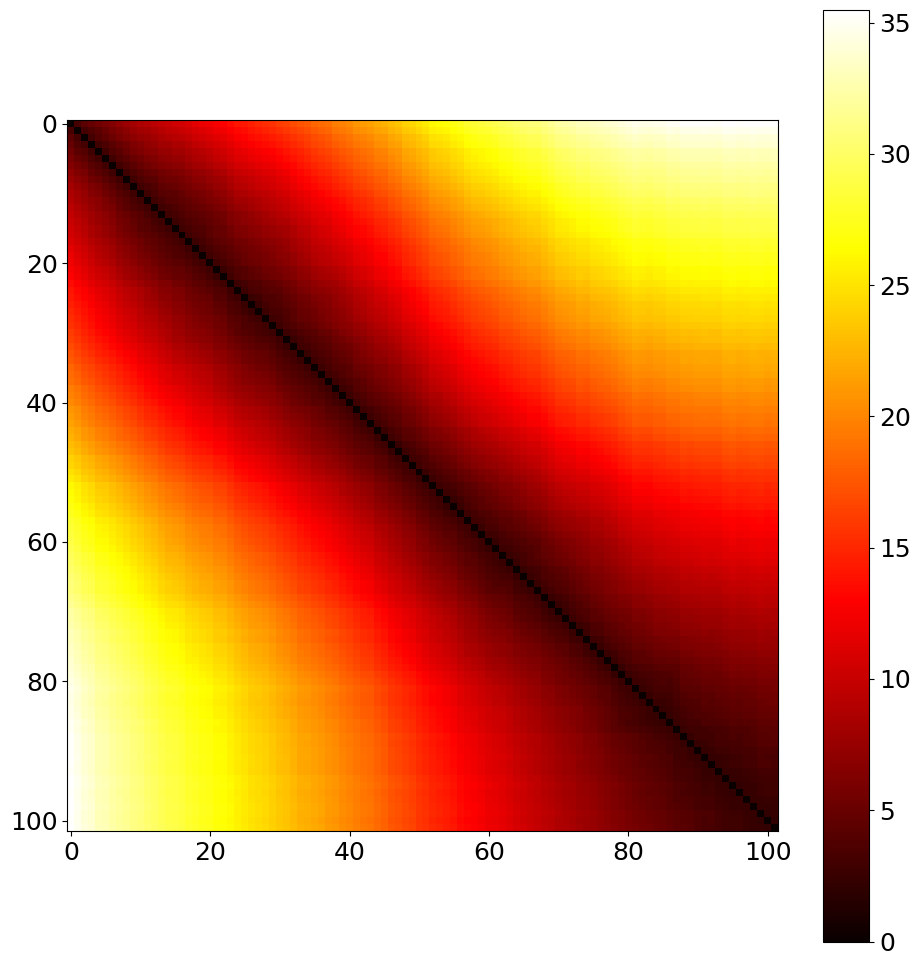

In [48]:
# plot heatmap of dataset.pairwise_distances using matplotlib
pwd = dataset.pairwise_distances
deltas = pwd[0, 1:] - pwd[0, :-1]
print(f'Differences between distances between timesteps: {deltas}')
# plot deltas using matplotlib
plt.figure(figsize=(10, 10))
plt.plot(range(len(deltas)), deltas)

plt.figure(figsize=(10,10))
plt.imshow(dataset.pairwise_distances, cmap='hot', interpolation='nearest')
# add legend
plt.colorbar()

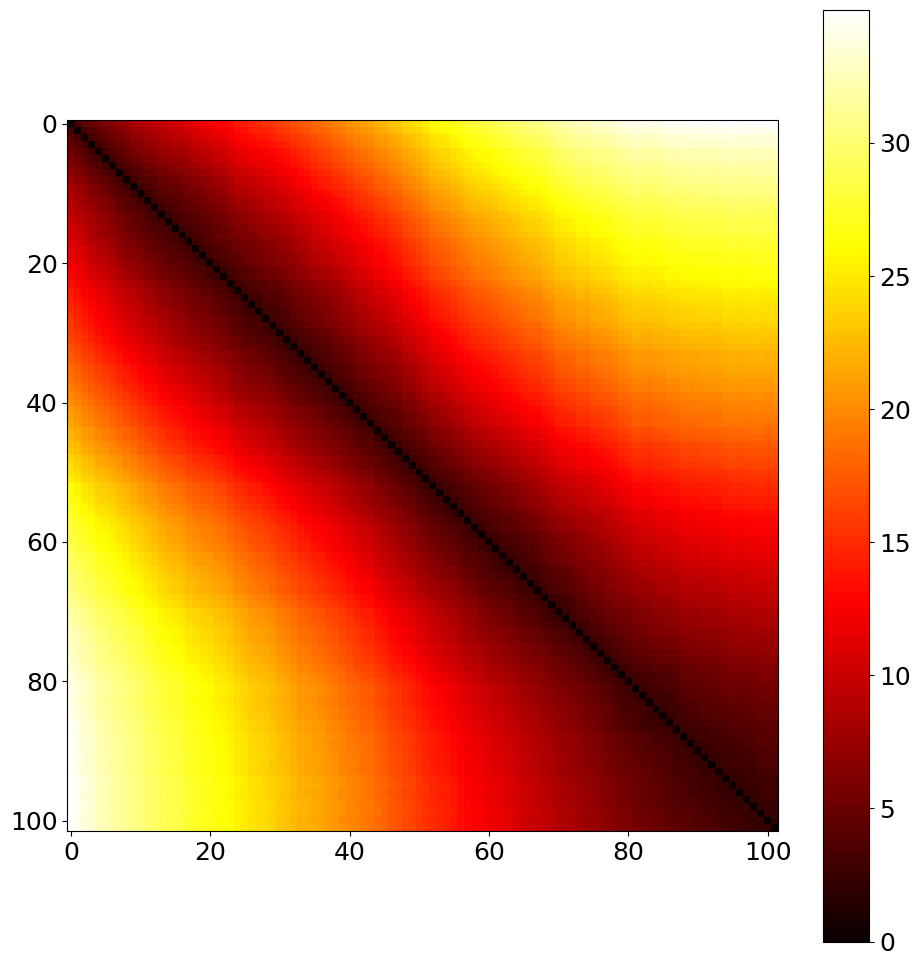

In [45]:
plt.figure(figsize=(10,10))
plt.imshow(dataset.pw_dist, cmap='hot', interpolation='nearest')
# add legend
plt.colorbar()

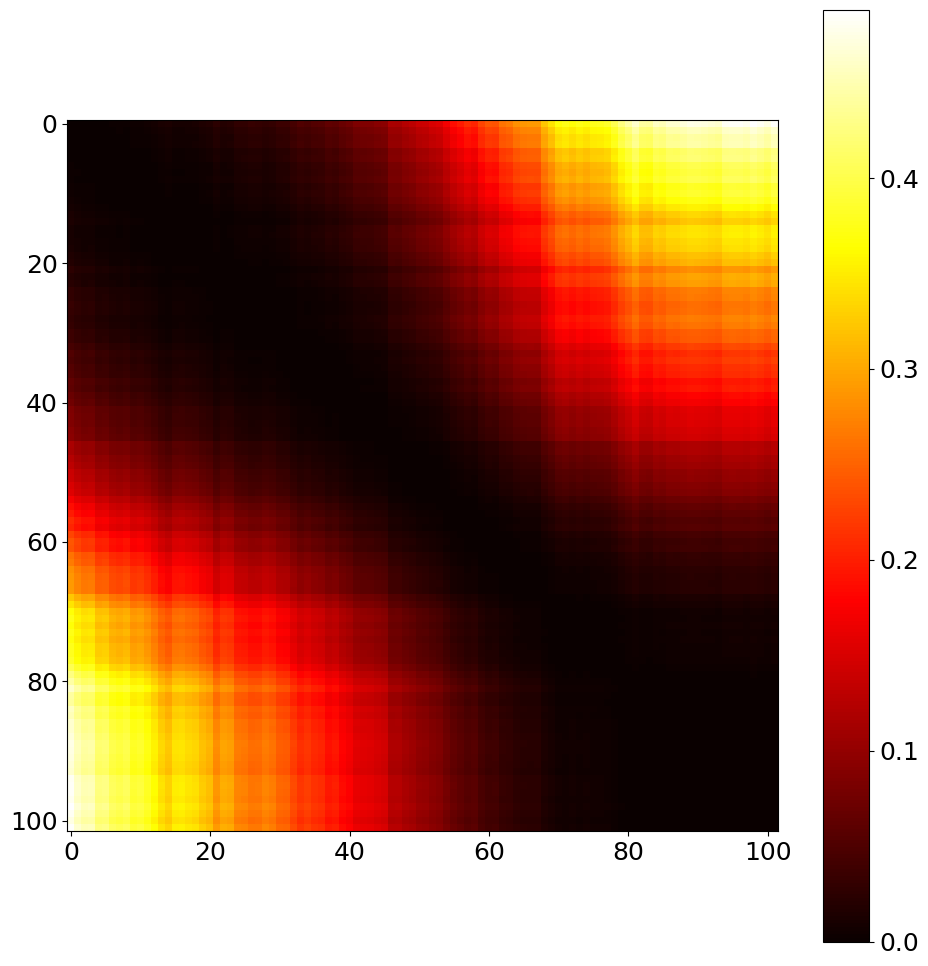

In [46]:
plt.figure(figsize=(10, 10))
plt.imshow(dataset.corrections, cmap='hot', interpolation='nearest')
# add legend
plt.colorbar()

In [30]:
class DistanceException(Exception):
    pass

def check_triangle_inequality():
    # Generate three unique random integers using PyTorch
    indices = torch.randperm(dataset.pairwise_distances.shape[0])[:3]
    
    # Sort the integers in increasing order
    indices = torch.sort(indices).values
    
    print(f'Vertex A: {indices[0]}, Vertex B: {indices[1]}, Vertex C: {indices[2]}')
    print(f'A-B distance: {dataset.pairwise_distances[indices[0], indices[1]]}')
    print(f'B-C distance: {dataset.pairwise_distances[indices[1], indices[2]]}')
    
    distance_no_hop = dataset.pairwise_distances[indices[0], indices[2]]
    print(f'A-C distance: {distance_no_hop}')
    
    distance_with_hop = dataset.pairwise_distances[indices[0], indices[1]] + dataset.pairwise_distances[indices[1], indices[2]]
    print(f'A-B-C distance: {distance_with_hop}')
    
    if distance_with_hop > distance_no_hop:
        raise DistanceException('Hop is not efficient')

In [31]:
n_tries = 100
counter = 0
for i in range(n_tries):
    try:
        check_triangle_inequality()
    except DistanceException as e:
        counter += 1
        
print(f'Number of times the triangle inequality was true: {counter}')

Vertex A: 5, Vertex B: 9, Vertex C: 88
A-B distance: 4.999456405639648
B-C distance: 30.503028869628906
A-C distance: 32.18409729003906
A-B-C distance: 35.50248718261719
Vertex A: 21, Vertex B: 40, Vertex C: 47
A-B distance: 9.99483585357666
B-C distance: 5.390885353088379
A-C distance: 13.363751411437988
A-B-C distance: 15.385721206665039
Vertex A: 15, Vertex B: 75, Vertex C: 101
A-B distance: 26.232236862182617
B-C distance: 7.5044121742248535
A-C distance: 28.668140411376953
A-B-C distance: 33.73664855957031
Vertex A: 22, Vertex B: 57, Vertex C: 94
A-B distance: 18.249725341796875
B-C distance: 12.768464088439941
A-C distance: 26.308340072631836
A-B-C distance: 31.0181884765625
Vertex A: 30, Vertex B: 54, Vertex C: 79
A-B distance: 13.19408130645752
B-C distance: 11.494580268859863
A-C distance: 21.522951126098633
A-B-C distance: 24.688661575317383
Vertex A: 20, Vertex B: 62, Vertex C: 65
A-B distance: 20.524368286132812
B-C distance: 3.2982070446014404
A-C distance: 21.508890151977

In [33]:
import networkx as nx
src_index = 0
# compute spanning tree from src_index as starting point
paths = nx.single_source_shortest_path(dataset.graph, src_index)

In [34]:
paths

{0: [0],
 1: [0, 1],
 2: [0, 2],
 3: [0, 3],
 4: [0, 4],
 5: [0, 5],
 6: [0, 6],
 7: [0, 7],
 8: [0, 8],
 9: [0, 9],
 10: [0, 10],
 11: [0, 11],
 12: [0, 12],
 13: [0, 13],
 14: [0, 14],
 15: [0, 15],
 16: [0, 16],
 17: [0, 17],
 18: [0, 18],
 19: [0, 19],
 20: [0, 20],
 21: [0, 21],
 22: [0, 22],
 23: [0, 23],
 24: [0, 24],
 25: [0, 25],
 26: [0, 26],
 27: [0, 27],
 28: [0, 28],
 29: [0, 29],
 30: [0, 30],
 31: [0, 31],
 32: [0, 32],
 33: [0, 33],
 34: [0, 34],
 35: [0, 35],
 36: [0, 36],
 37: [0, 37],
 38: [0, 38],
 39: [0, 39],
 40: [0, 40],
 41: [0, 41],
 42: [0, 42],
 43: [0, 43],
 44: [0, 44],
 45: [0, 45],
 46: [0, 46],
 47: [0, 47],
 48: [0, 48],
 49: [0, 49],
 50: [0, 50],
 51: [0, 51],
 52: [0, 52],
 53: [0, 53],
 54: [0, 54],
 55: [0, 55],
 56: [0, 56],
 57: [0, 57],
 58: [0, 58],
 59: [0, 59],
 60: [0, 60],
 61: [0, 61],
 62: [0, 62],
 63: [0, 63],
 64: [0, 64],
 65: [0, 65],
 66: [0, 66],
 67: [0, 67],
 68: [0, 68],
 69: [0, 69],
 70: [0, 70],
 71: [0, 71],
 72: [0, 72],
 

## Construct manifold ##

In [27]:
ca_pos[None].shape
# should be B x L x N x D (batch_id? x traj_length x num_atoms x dim)

torch.Size([1, 102, 214, 3])

In [4]:
# construct manifold
num_atoms = ca_pos.shape[1]
manifold = PointCloud(3, num_atoms, base=ca_pos[0], alpha=1.)

# constuct rotation matrix
rot_xz = torch.zeros(3,3)
rot_xz[2,0] = 1.
rot_xz[1,1] = 1.
rot_xz[0,2] = -1.
manifold.base_point = torch.einsum("ba,ia->ib", rot_xz, manifold.base_point)

rot_xy = torch.zeros(3,3)
theta = torch.tensor([- torch.pi * 1/3])
rot_xy[0,0] = torch.cos(theta)
rot_xy[0,1] = - torch.sin(theta)
rot_xy[1,0] = torch.sin(theta)
rot_xy[1,1] = torch.cos(theta)
rot_xy[2,2] = 1.
manifold.base_point = torch.einsum("ba,ia->ib", rot_xy, manifold.base_point)

# align all proteins with base
proteins = manifold.align_mpoint(ca_pos[None], base=manifold.base_point).squeeze()

102


## Separation-geodesic interpolating ##

In [6]:
t_steps = 21
p0 = proteins[0]
p1 = proteins[-1]
T = torch.linspace(0,1,t_steps) # torch.tensor([1/4,1/2,3/4]) # torch.tensor([1/2])
pt = torch.zeros(t_steps, protein_len, 3)
mdt = torch.zeros(t_steps, protein_len, 3)

for i,t in enumerate(T):
    print(f"computing geodesic {i+1}")
    md_ind = int(i/(t_steps-1) * (num_proteins-1))
    pt[i] = manifold.s_geodesic(p0[None,None], p1[None,None], torch.tensor([t]), debug=True).squeeze()
    mdt[i] = proteins[md_ind]
    
%timeit manifold.s_geodesic(p0[None,None], p1[None,None], torch.tensor([T[int(t_steps/2)]]))

computing geodesic 1
1 | relerror = 1.3062247037887573
2 | relerror = 0.5231971740722656
3 | relerror = 0.09502189606428146
4 | relerror = 0.006523853167891502
5 | relerror = 5.61239430680871e-05
computing geodesic 2
1 | relerror = 1.242348074913025
2 | relerror = 0.4736263155937195
3 | relerror = 0.08295956999063492
4 | relerror = 0.005844831001013517
5 | relerror = 5.648899241350591e-05
computing geodesic 3
1 | relerror = 1.1384340524673462
2 | relerror = 0.42824962735176086
3 | relerror = 0.0634889304637909
4 | relerror = 0.003579831449314952
5 | relerror = 4.385551073937677e-05
computing geodesic 4
1 | relerror = 1.0604554414749146
2 | relerror = 0.38384920358657837
3 | relerror = 0.046048492193222046
4 | relerror = 0.0017538248794153333
5 | relerror = 3.3620955946389586e-05
computing geodesic 5
1 | relerror = 0.9889008402824402
2 | relerror = 0.340004563331604
3 | relerror = 0.033966027200222015
4 | relerror = 0.0010036525782197714
5 | relerror = 2.562391455285251e-05
computing ge

<function matplotlib.pyplot.show(close=None, block=None)>

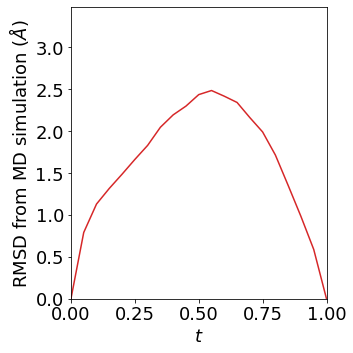

In [8]:
# compute RMSD in Anstrom for geodesics vs trajectory
rmsd_T = torch.sqrt(torch.sum((pt - mdt) ** 2,[1,2]) / protein_len)

# plot 
fig_size = 21 # cm
plt.figure(figsize=(fig_size/4, fig_size/4))
plt.plot(T, rmsd_T, 'tab:red')
plt.xlim([0,1])
plt.ylim([0,rmsd_T.max()+1])
plt.xlabel(r'$t$')
plt.ylabel(r'RMSD from MD simulation ($\AA$)')
# save figure
plt.savefig(os.path.join(results_folder,fig_prefix +f'_RMSD_progression_md'+formt))
plt.show


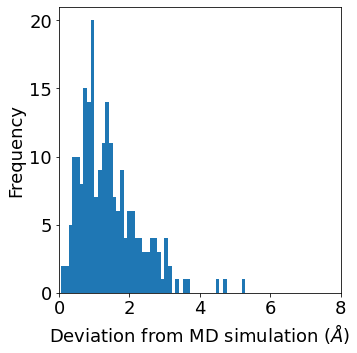

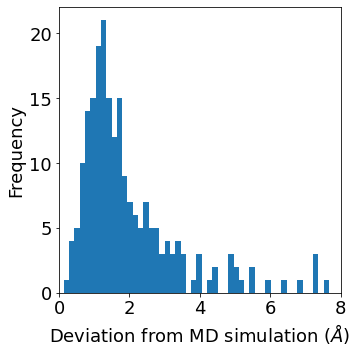

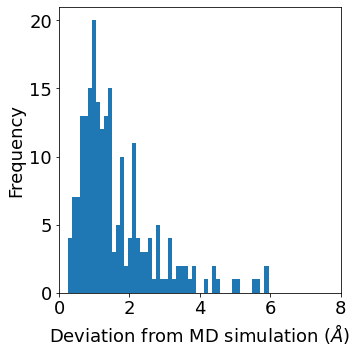

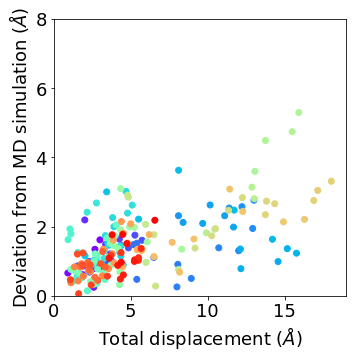

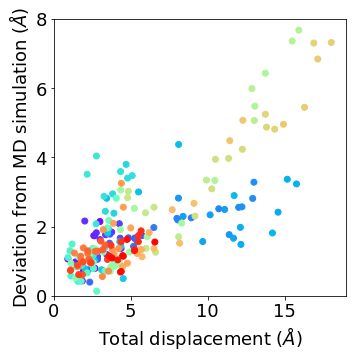

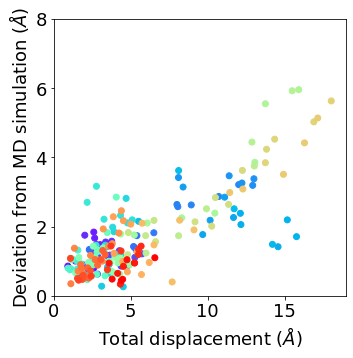

In [9]:
d_T = torch.sqrt(torch.sum((pt - mdt) ** 2, -1))
d_total = torch.sqrt(torch.sum((proteins[0] - proteins[-1]) ** 2, -1))

max_error = int(torch.max(d_T)) + 1
max_displacement = int(torch.max(d_total)) + 1

num_figs = 3
fig_size = 21 # cm
for i in range(num_figs):
    g_ind = int((i+1)/(num_figs+1) * (t_steps-1))
    ax = plt.figure(figsize=(fig_size/4, fig_size/4))
    plt.hist(d_T[g_ind][None], bins=50)
    plt.xlim([0, max_error])
    plt.ylabel('Frequency')
    plt.xlabel(r'Deviation from MD simulation ($\AA$)')
plt.show()

# fig = plt.figure(figsize=(fig_size, fig_size/num_figs))
for i in range(num_figs):
    g_ind = int((i+1)/(num_figs+1) * (t_steps-1))
    md_ind = int((i+1)/(num_figs+1) * (num_proteins-1))
    plt.figure(figsize=(fig_size/4, fig_size/4))
    plt.scatter(d_total,d_T[g_ind], c = torch.linspace(0,1,protein_len), cmap = 'rainbow')
    plt.ylim([0, max_error])
    plt.xlim([0, max_displacement])
    plt.xlabel(r'Total displacement ($\AA$)')
    plt.ylabel(r'Deviation from MD simulation ($\AA$)')
    # save figure
    plt.savefig(os.path.join(results_folder,fig_prefix +f'_displacement_vs_error_{g_ind}f{t_steps-1}_md_{md_ind}'+formt))
plt.show()

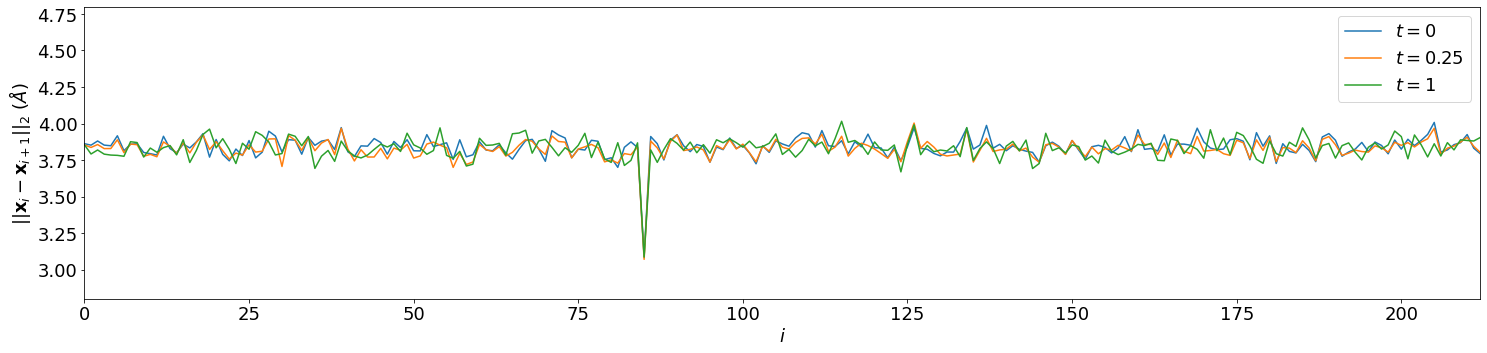

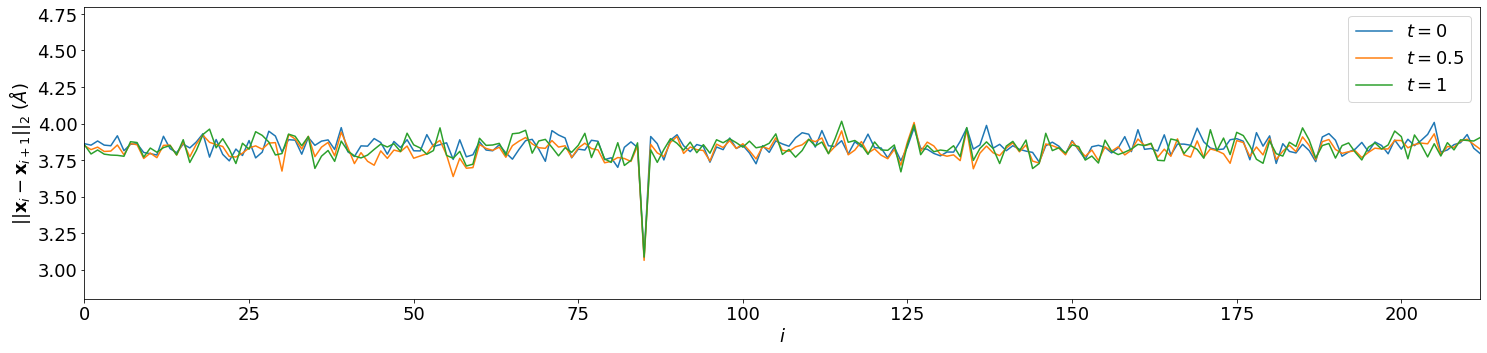

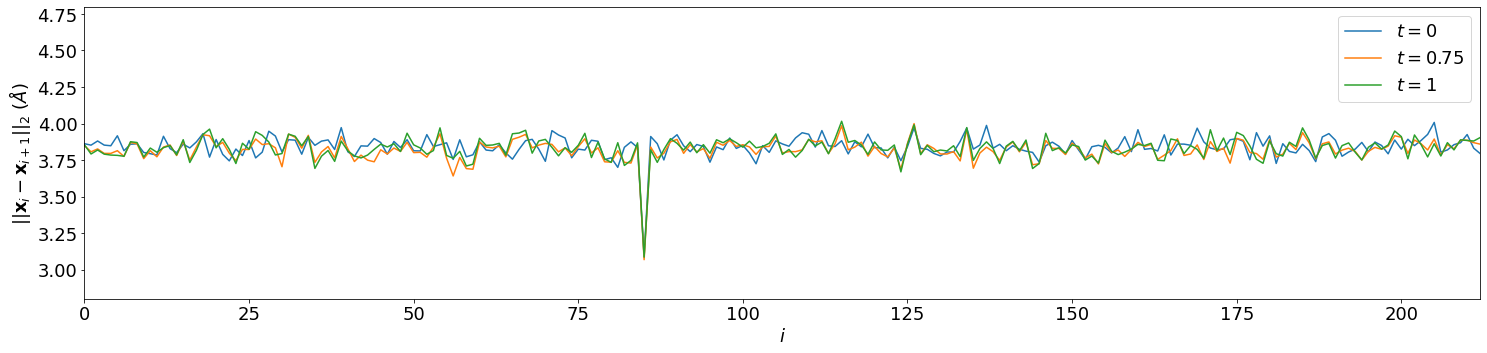

In [10]:
pt_pairwise_distances = manifold.pairwise_distances(pt[None]).squeeze()
pt_adj_pairwise_distances = torch.diagonal(pt_pairwise_distances,offset=1, dim1=1, dim2=2)

num_figs = 3
fig_size = 21 # cm

for i in range(num_figs):
    plt.figure(figsize=(fig_size, fig_size/4))
    g_ind = int((i+1)/(num_figs+1) * (t_steps-1))
    plt.plot(range(protein_len-1), torch.sqrt(pt_adj_pairwise_distances[0]), label=r'$t=0$')
    plt.plot(range(protein_len-1), torch.sqrt(pt_adj_pairwise_distances[g_ind]), label=r'$t=$' +f'{T[g_ind]}')
    plt.plot(range(protein_len-1), torch.sqrt(pt_adj_pairwise_distances[-1]), label=r'$t=1$')
    plt.xlim([0, protein_len-2])
    plt.ylim([2.8,4.8])
    plt.ylabel(r'$\|\|\mathbf{x}_i - \mathbf{x}_{i+1}\|\|_2$ ($\AA$)')
    plt.xlabel(r'$i$')
    plt.legend()
    # save figure
    plt.savefig(os.path.join(results_folder,fig_prefix +f'_adjacent_residue_{g_ind}f{t_steps-1}'+formt)) 
plt.show()

## Separation-barycentre of the trajectory ##

In [11]:
p_barycentre = manifold.s_mean(proteins[None], x0=proteins[int(num_proteins/2)][None,None], debug=True).squeeze()
%timeit manifold.s_mean(proteins[None], x0=proteins[int(num_proteins/2)][None,None]).squeeze()

1 | relerror = 0.04131796956062317
2 | relerror = 0.0048988861963152885
3 | relerror = 0.00014780634955968708
425 ms ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
p_barycentre_pairwise_distances = manifold.pairwise_distances(p_barycentre[None,None]).squeeze()
p_barycentre_adj_pairwise_distances = torch.diagonal(p_barycentre_pairwise_distances,1)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  

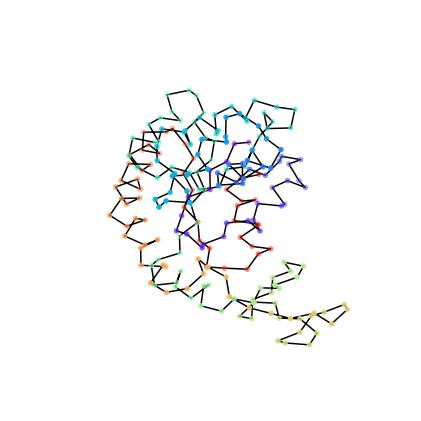

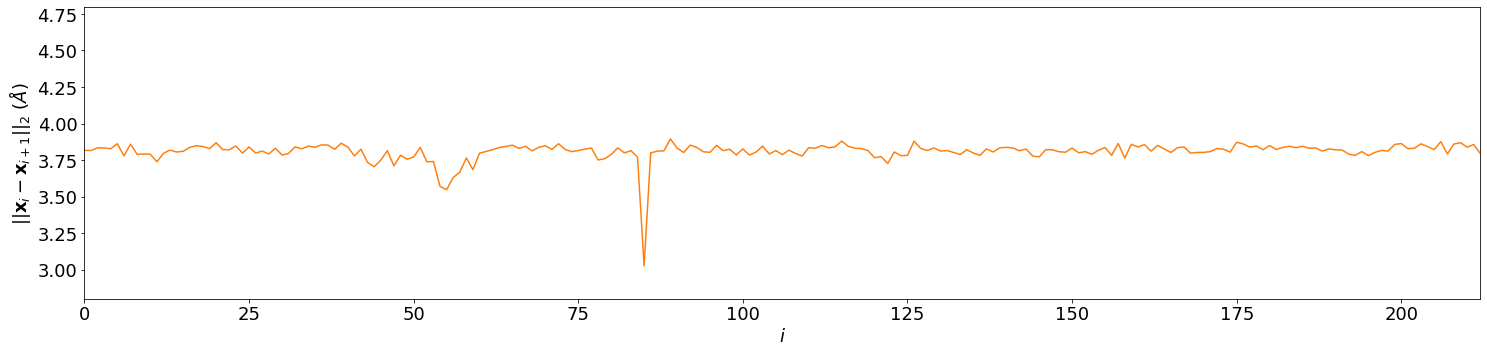

In [13]:
fig_size = 31 * (protein_len/214) ** (1/3) # cm

fig = plt.figure(figsize=(fig_size/5, fig_size/5))
ax = plt.axes(projection='3d')
ax.plot3D(p_barycentre[:,0], p_barycentre[:,1], p_barycentre[:,2], 'black')
ax.scatter(p_barycentre[:,0], p_barycentre[:,1], p_barycentre[:,2], c = torch.linspace(0,1,protein_len), cmap = 'rainbow')
ax.axes.set_xlim3d(left=-bbox, right=bbox) 
ax.axes.set_ylim3d(bottom=-bbox, top=bbox) 
ax.axes.set_zlim3d(bottom=-bbox, top=bbox) 
ax.set_axis_off() 
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig(os.path.join(results_folder,f'4ake_barycentre'+formt), bbox_inches=extent.expanded(0.8, 0.8))
plt.show()

fig_size = 21 # cm
plt.figure(figsize=(fig_size, fig_size/4))
plt.plot(range(protein_len-1), torch.sqrt(p_barycentre_adj_pairwise_distances), color='tab:orange')
plt.xlim([0, protein_len-2])
plt.ylim([2.8,4.8])
plt.ylabel(r'$\|\|\mathbf{x}_i - \mathbf{x}_{i+1}\|\|_2$ ($\AA$)')
plt.xlabel(r'$i$')
# save figure
# extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig(os.path.join(results_folder,fig_prefix +f'_adjacent_residue_barycentre'+formt)) 
plt.show()

## Separation-logarithmic map for low rank approximation ##

In [14]:
# compute logs to all points from pt
log_p_barycentre = manifold.s_log(p_barycentre[None,None], proteins[None]).squeeze()
%timeit manifold.s_log(p_barycentre[None,None], proteins[None]).squeeze()

115 ms ± 3.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


tensor([3.3351e-03, 3.2004e+00, 3.6318e+00, 3.7948e+00, 4.0651e+00, 4.2062e+00,
        4.3745e+00, 4.4336e+00, 4.4784e+00, 4.7487e+00, 4.7863e+00, 5.1467e+00,
        5.4581e+00, 5.4585e+00, 5.6202e+00, 5.8394e+00, 5.9500e+00, 6.2104e+00,
        6.3764e+00, 6.6530e+00, 6.7007e+00, 7.0974e+00, 7.1536e+00, 7.3274e+00,
        7.6407e+00, 7.8282e+00, 7.8964e+00, 8.2776e+00, 8.3402e+00, 8.5688e+00,
        8.9431e+00, 9.2665e+00, 9.3530e+00, 9.6314e+00, 9.8228e+00, 9.9515e+00,
        9.9831e+00, 1.0319e+01, 1.0654e+01, 1.0828e+01, 1.1129e+01, 1.1536e+01,
        1.1868e+01, 1.2062e+01, 1.2441e+01, 1.2859e+01, 1.3320e+01, 1.3650e+01,
        1.3876e+01, 1.3979e+01, 1.4914e+01, 1.4992e+01, 1.5310e+01, 1.5962e+01,
        1.6151e+01, 1.6860e+01, 1.7108e+01, 1.7379e+01, 1.8068e+01, 1.8089e+01,
        1.8902e+01, 1.9235e+01, 1.9417e+01, 2.0660e+01, 2.1575e+01, 2.1853e+01,
        2.2338e+01, 2.2864e+01, 2.3504e+01, 2.4883e+01, 2.5542e+01, 2.6658e+01,
        2.8583e+01, 2.9145e+01, 3.0490e+

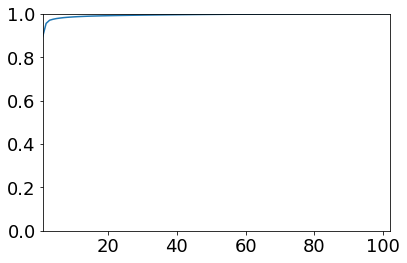

In [15]:
# compute gramm matrix
# Gramm_mat = manifold.inner(p_barycentre[None,None], log_p_barycentre[None,None],log_p_barycentre[None,None]).squeeze()
Gramm_mat = torch.einsum("Nia,Mia->NM",log_p_barycentre,log_p_barycentre)
L, U = torch.linalg.eigh(Gramm_mat)
R_p_barycentre = torch.einsum("NM,Nia->Mia", U, log_p_barycentre)

# print eigenvalues
print(L)
th = 0.85
rank = int(torch.linspace(1,len(L),len(L))[L.flip(0).cumsum(0)/L.sum() > th].min())
print(rank)

plt.figure()
plt.plot(torch.linspace(1,len(L),len(L)), L.flip(0).cumsum(0)/L.sum())
plt.xlim([1, len(L)])
plt.ylim([0, 1])
plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  

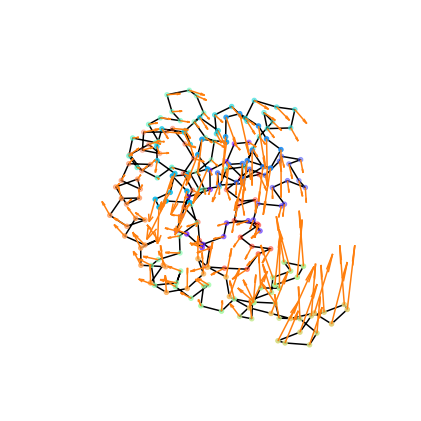

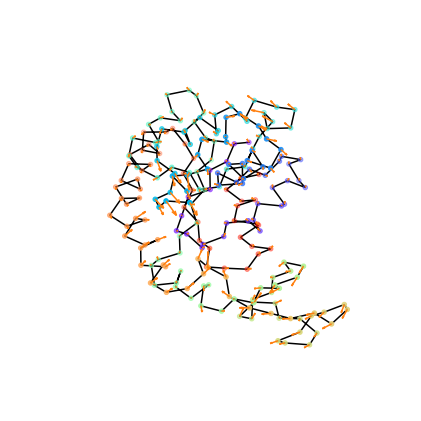

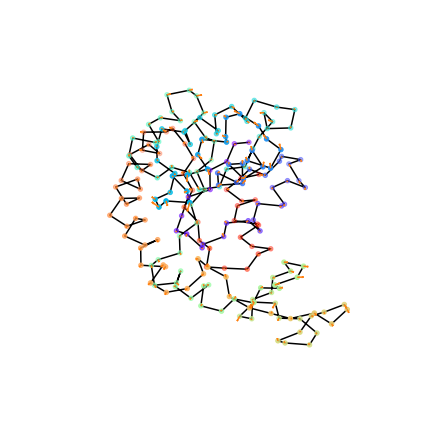

In [16]:
s = 0.2
fig_size = 31 * (protein_len/214) ** (1/3) # cm
num_figs = rank +2
for i in range(num_figs):
    plt.figure(figsize=(fig_size/5, fig_size/5))
    ax = plt.axes(projection='3d')
    ax.plot3D(p_barycentre[:,0], p_barycentre[:,1], p_barycentre[:,2], 'black')
    ax.scatter(p_barycentre[:,0], p_barycentre[:,1], p_barycentre[:,2], c = torch.linspace(0,1,protein_len), cmap = 'rainbow')
    ax.quiver(p_barycentre[:, 0], p_barycentre[:, 1], p_barycentre[:, 2], s * R_p_barycentre[-(i+1),:, 0], s * R_p_barycentre[-(i+1),:, 1], s * R_p_barycentre[-(i+1),:, 2],color='tab:orange')
    ax.axes.set_xlim3d(left=-bbox, right=bbox) 
    ax.axes.set_ylim3d(bottom=-bbox, top=bbox) 
    ax.axes.set_zlim3d(bottom=-bbox, top=bbox) 
    ax.set_axis_off() 
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig(os.path.join(results_folder,fig_prefix +f'_barycentre_tvector_{i}'+formt), bbox_inches=extent.expanded(0.8, 0.8))
plt.show()

In [17]:
log_p_barycentre_r = torch.einsum("Mia,NM->Nia", R_p_barycentre[num_proteins-rank:num_proteins],U[:,num_proteins-rank:num_proteins])

log_p_barycentre_t = torch.zeros(t_steps, protein_len, 3)
log_p_barycentre_t_r = torch.zeros(t_steps, protein_len, 3)
mdt_r = torch.zeros(t_steps, protein_len, 3)
for i in range(t_steps):
    md_ind = int(i/(t_steps-1) * (num_proteins-1))
    print(f"computing approximation of protein {md_ind}")
    log_p_barycentre_t[i] = log_p_barycentre[md_ind]
    log_p_barycentre_t_r[i] = log_p_barycentre_r[md_ind]
    mdt_r[i] = manifold.s_exp(p_barycentre[None,None], log_p_barycentre_r[md_ind][None,None], c=1/4, step_size=1., debug=True).squeeze()
%timeit manifold.s_exp(p_barycentre[None,None], log_p_barycentre_r[md_ind][None,None], c=1/4, step_size=1.).squeeze()

computing approximation of protein 0
computing exp in 6 steps
1 | relerror = 1.029267430305481
2 | relerror = 0.037816766649484634
3 | relerror = 0.00011489874304970726
1 | relerror = 1.0285401344299316
2 | relerror = 0.035110510885715485
3 | relerror = 0.00012167893873993307
1 | relerror = 1.0272125005722046
2 | relerror = 0.033330947160720825
3 | relerror = 0.00014861700765322894
1 | relerror = 1.0252605676651
2 | relerror = 0.03279377892613411
3 | relerror = 0.00021427309548016638
1 | relerror = 1.0227268934249878
2 | relerror = 0.034140631556510925
3 | relerror = 0.0003229134017601609
computing approximation of protein 5
computing exp in 6 steps
1 | relerror = 1.0255225896835327
2 | relerror = 0.033161334693431854
3 | relerror = 7.546601409558207e-05
1 | relerror = 1.02513587474823
2 | relerror = 0.03096952475607395
3 | relerror = 7.707504119025543e-05
1 | relerror = 1.0243606567382812
2 | relerror = 0.029361268505454063
3 | relerror = 8.778427582001314e-05
1 | relerror = 1.0231432

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  

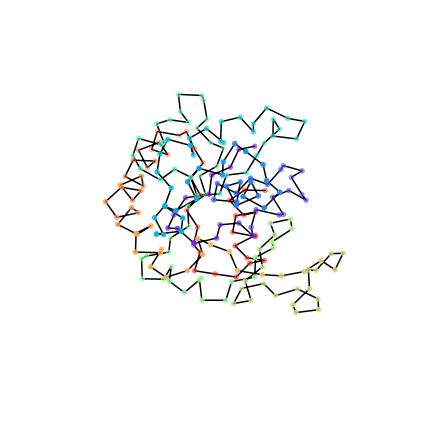

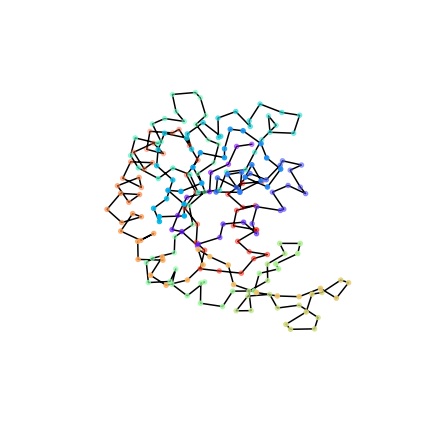

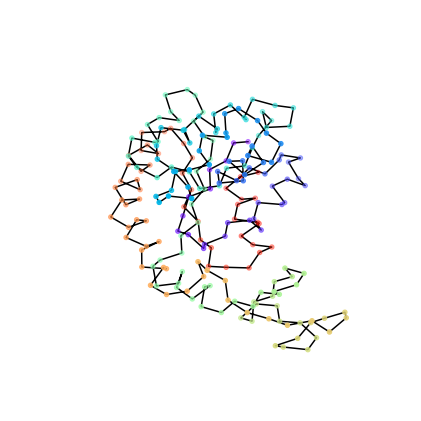

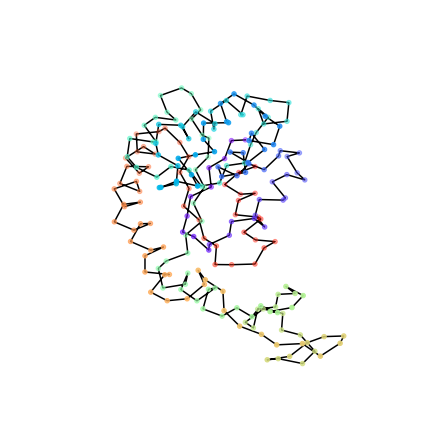

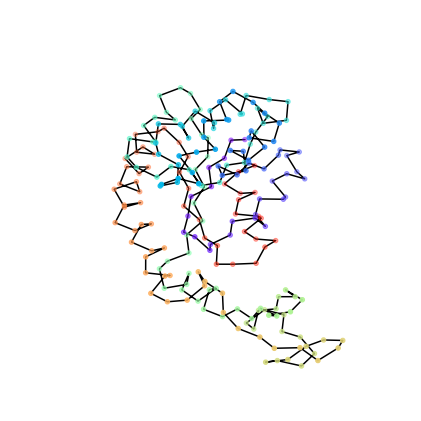

<function matplotlib.pyplot.show(close=None, block=None)>

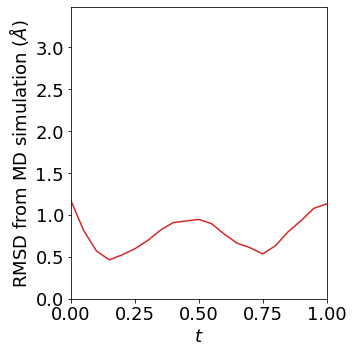

In [18]:
fig_size = 31 * (protein_len/214) ** (1/3) # cm
num_figs=5
for i in range(num_figs):
    g_ind = int(i/(num_figs-1) * (t_steps-1))
    md_ind = int(i/(num_figs-1) * (num_proteins-1))
    fig = plt.figure(figsize=(fig_size/5, fig_size/5))
    ax = plt.axes(projection='3d')
    ax.plot3D(mdt_r[g_ind,:,0],mdt_r[g_ind,:,1],mdt_r[g_ind,:,2], 'black')
    ax.scatter(mdt_r[g_ind,:,0],mdt_r[g_ind,:,1],mdt_r[g_ind,:,2], c = torch.linspace(0,1,protein_len), cmap = 'rainbow')
    ax.axes.set_xlim3d(left=-bbox, right=bbox) 
    ax.axes.set_ylim3d(bottom=-bbox, top=bbox) 
    ax.axes.set_zlim3d(bottom=-bbox, top=bbox) 
    ax.set_axis_off() 
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig(os.path.join(results_folder,fig_prefix +f'_rank_{rank}_{g_ind}f{t_steps-1}_md_{md_ind}'+formt), bbox_inches=extent.expanded(0.8, 0.8))
plt.show()

# compute RMSD in Anstrom for geodesics vs trajectory
rmsd_T_r = torch.sqrt(torch.sum((mdt_r - mdt) ** 2,[1,2]) / protein_len)

# scatter plot 

fig_size = 21 # cm
plt.figure(figsize=(fig_size/4, fig_size/4))
plt.plot(T, rmsd_T_r, 'tab:red')
plt.xlim([0,1])
plt.ylim([0,rmsd_T.max()+1])
plt.xlabel(r'$t$')
plt.ylabel(r'RMSD from MD simulation ($\AA$)')
# save figure
# extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig(os.path.join(results_folder,fig_prefix +f'_RMSD_progression_rank_{rank}'+formt))
plt.show

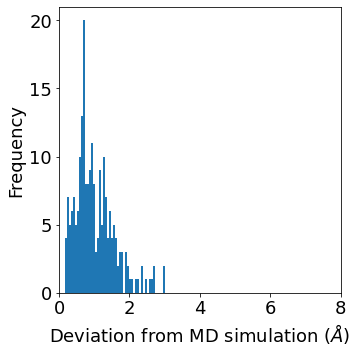

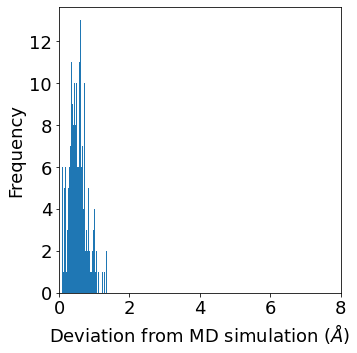

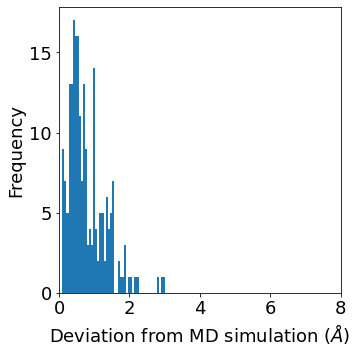

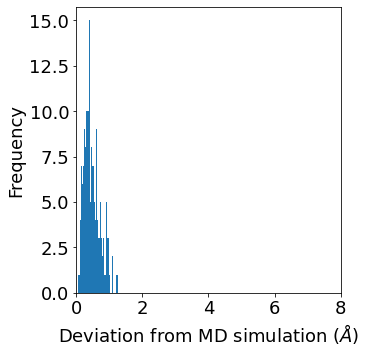

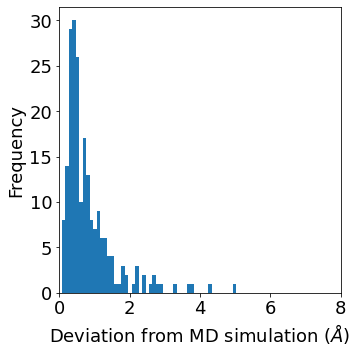

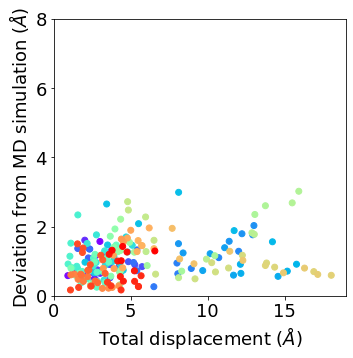

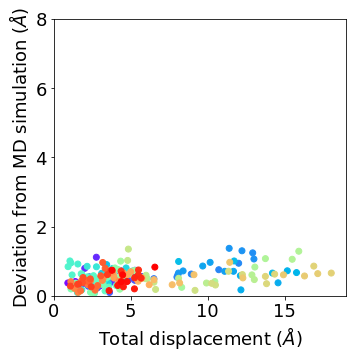

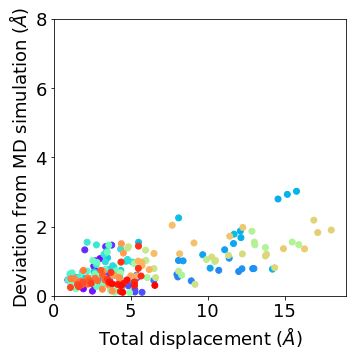

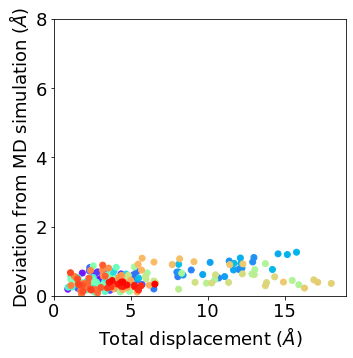

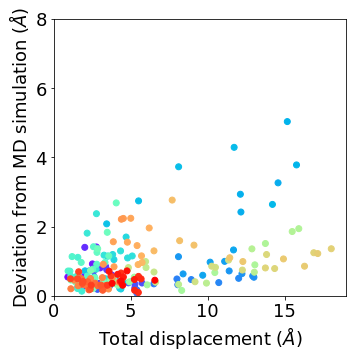

In [19]:
d_T_r = torch.sqrt(torch.sum((mdt_r - mdt) ** 2, -1))

# max_error = int(torch.max(d_T_r)) + 1
max_displacement = int(torch.max(d_total)) + 1

num_figs = 5
fig_size = 21 # cm
for i in range(num_figs):
    g_ind = int(i/(num_figs-1) * (t_steps-1))
    ax = plt.figure(figsize=(fig_size/4, fig_size/4))
    plt.hist(d_T_r[g_ind][None], bins=50)
    plt.xlim([0, max_error])
    plt.ylabel('Frequency')
    plt.xlabel(r'Deviation from MD simulation ($\AA$)')
plt.show()

for i in range(num_figs):
    g_ind = int(i/(num_figs-1) * (t_steps-1))
    md_ind = int(i/(num_figs-1) * (num_proteins-1))
    plt.figure(figsize=(fig_size/4, fig_size/4))
    plt.scatter(d_total,d_T_r[g_ind], c = torch.linspace(0,1,protein_len), cmap = 'rainbow')
    plt.ylim([0, max_error])
    plt.xlim([0, max_displacement])
    plt.xlabel(r'Total displacement ($\AA$)')
    plt.ylabel(r'Deviation from MD simulation ($\AA$)')
    # save figure
    plt.savefig(os.path.join(results_folder,fig_prefix +f'_displacement_vs_error_rank_{rank}_md_{md_ind}'+formt))
plt.show()

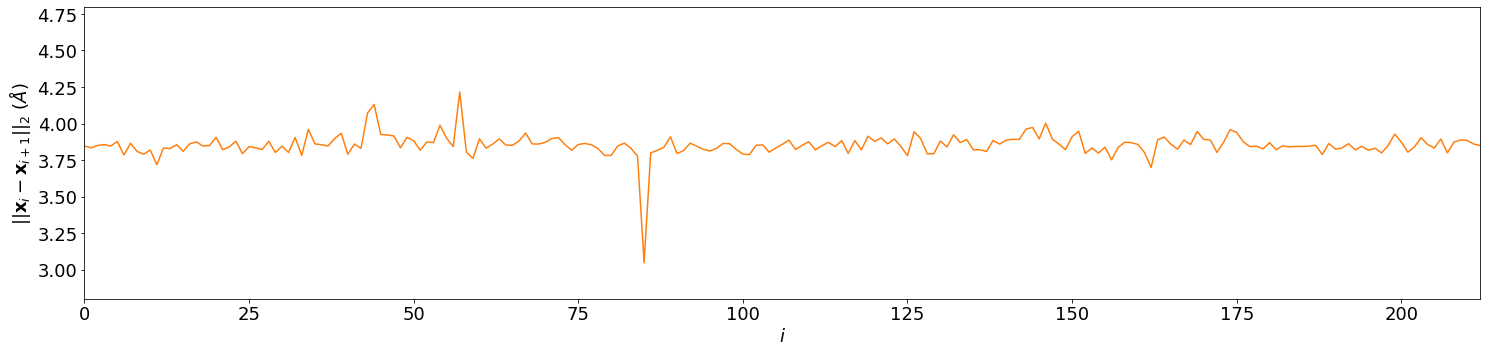

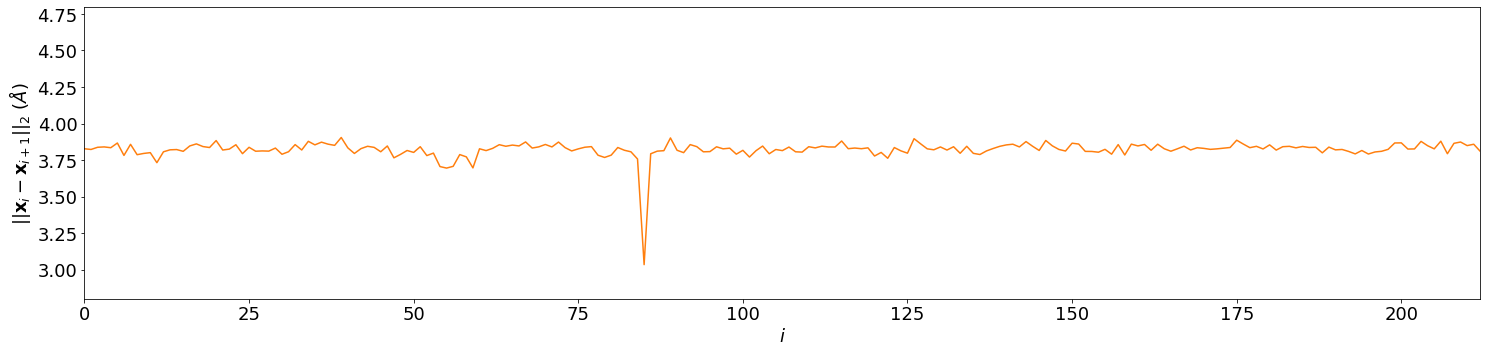

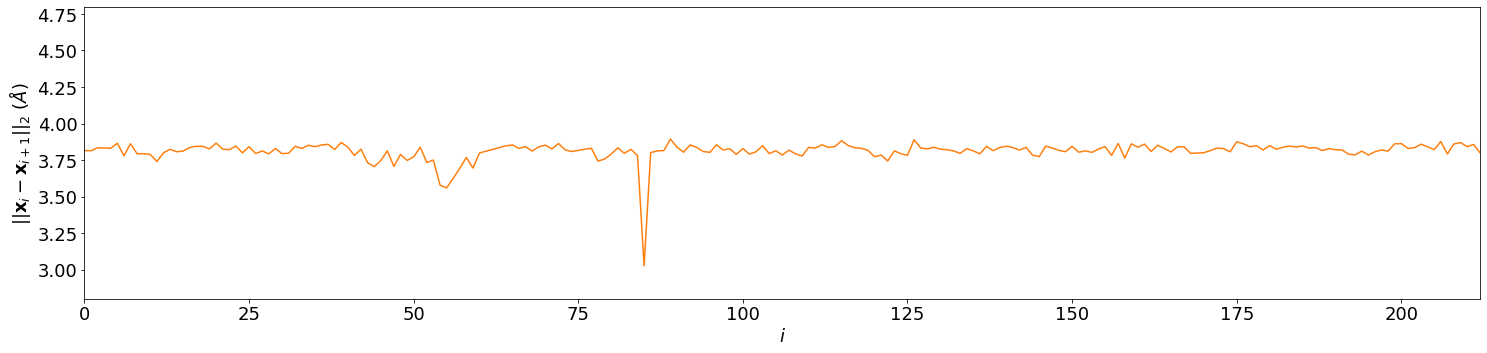

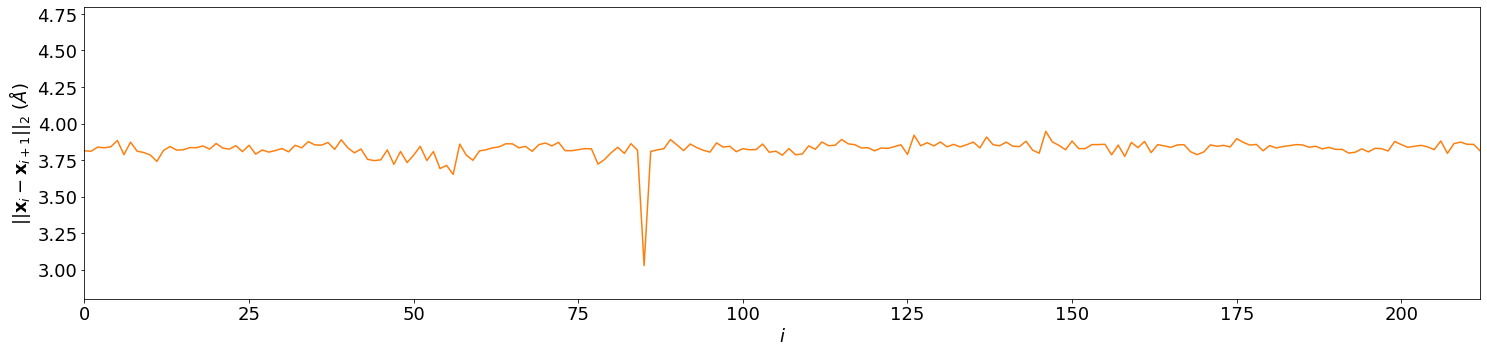

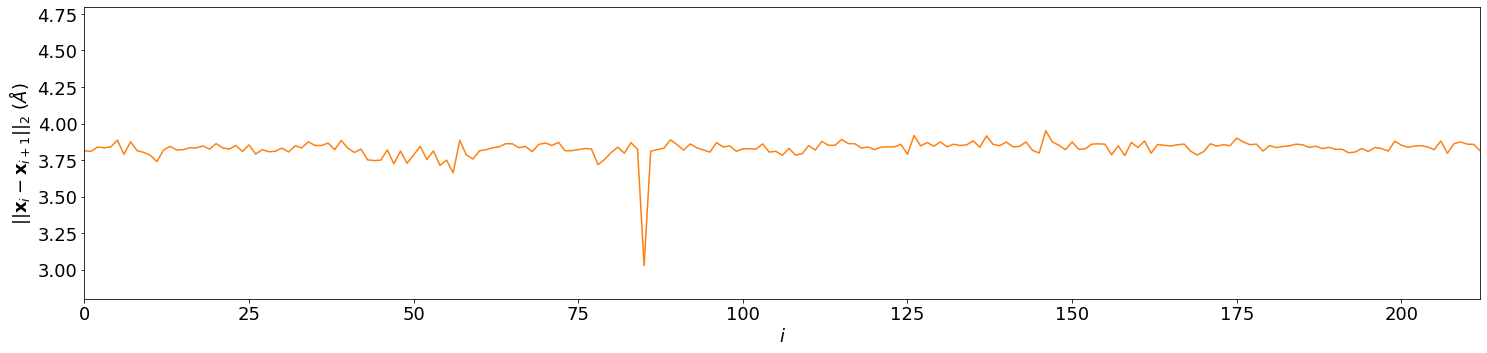

In [20]:
mdt_r_pairwise_distances = manifold.pairwise_distances(mdt_r[None]).squeeze()
mdt_r_adj_pairwise_distances = torch.diagonal(mdt_r_pairwise_distances,offset=1, dim1=1, dim2=2)

num_figs = 5
fig_size = 21 # cm

for i in range(num_figs):
    plt.figure(figsize=(fig_size, fig_size/4))
    g_ind = int(i/(num_figs-1) * (t_steps-1))
    plt.plot(range(protein_len-1), torch.sqrt(mdt_r_adj_pairwise_distances[g_ind]), color='tab:orange')
    plt.xlim([0, protein_len-2])
    plt.ylim([2.8,4.8])
    plt.ylabel(r'$\|\|\mathbf{x}_i - \mathbf{x}_{i+1}\|\|_2$ ($\AA$)')
    plt.xlabel(r'$i$')
    # save figure
    plt.savefig(os.path.join(results_folder,fig_prefix +f'_adjacent_residue_{g_ind}f{t_steps-1}_mdt_r_rank_{rank}'+formt)) 
plt.show()

## Stability with respect to curvature ##

In [21]:
# so first we want to do geodesic variation
# start from different starting points in the data and go to same end
v_index = 3
pt_v0 = torch.zeros(t_steps, protein_len, 3)
pt_v1 = torch.zeros(t_steps, protein_len, 3)
p0_v = proteins[v_index]
p1_v = proteins[-1 - v_index]
for i,t in enumerate(T):
    print(f"computing geodesic {i+1} of variation {v_index}")
    pt_v0[i] = manifold.s_geodesic(p0_v[None,None], p1[None,None], torch.tensor([t]), debug=True).squeeze()
    pt_v1[i] = manifold.s_geodesic(p0[None,None], p1_v[None,None], torch.tensor([t]), debug=True).squeeze()

computing geodesic 1 of variation 3
1 | relerror = 1.28630530834198
2 | relerror = 0.4873600900173187
3 | relerror = 0.07966779917478561
4 | relerror = 0.004616053309291601
5 | relerror = 2.359628888370935e-05
1 | relerror = 1.3292007446289062
2 | relerror = 0.5323657989501953
3 | relerror = 0.09837322682142258
4 | relerror = 0.007126908283680677
5 | relerror = 5.470264295581728e-05
computing geodesic 2 of variation 3
1 | relerror = 1.1960148811340332
2 | relerror = 0.44242042303085327
3 | relerror = 0.06343076378107071
4 | relerror = 0.0029183842707425356
5 | relerror = 1.640650771150831e-05
1 | relerror = 1.2447969913482666
2 | relerror = 0.4823257327079773
3 | relerror = 0.08386192470788956
4 | relerror = 0.005835022311657667
5 | relerror = 5.4002910474082455e-05
computing geodesic 3 of variation 3
1 | relerror = 1.1196194887161255
2 | relerror = 0.3984159529209137
3 | relerror = 0.04830231890082359
4 | relerror = 0.0016032604034990072
5 | relerror = 1.6932941434788518e-05
1 | reler

<function matplotlib.pyplot.show(close=None, block=None)>

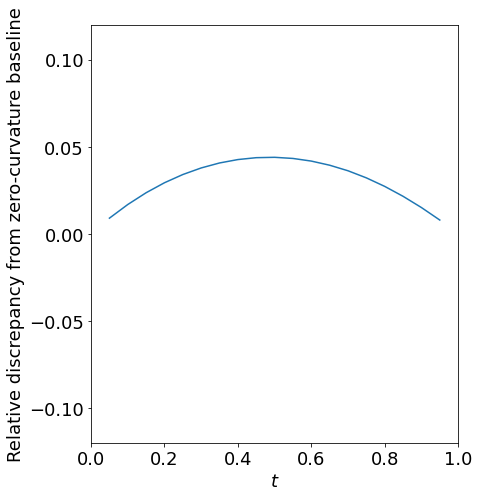

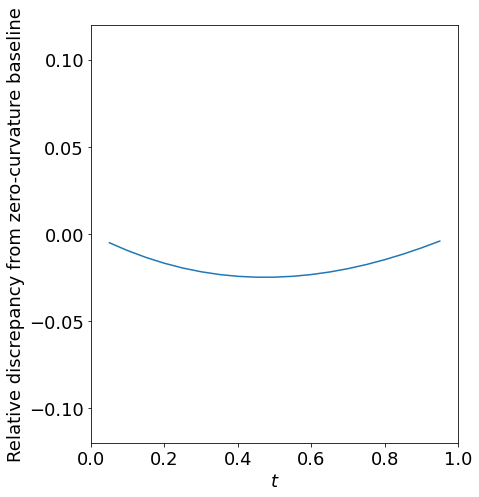

In [22]:
# compute RMSD in Anstrom for geodesics vs trajectory
rmsd_T_v0 = torch.sqrt(torch.sum((pt - pt_v0) ** 2,[1,2]) / protein_len)
rmsd_T_v1 = torch.sqrt(torch.sum((pt - pt_v1) ** 2,[1,2]) / protein_len)

# plot 
fig_size = 21 # cm
plt.figure(figsize=(fig_size/3, fig_size/3))
plt.plot(T[1:-1], (rmsd_T_v0 - (1 - T)*rmsd_T_v0[0])[1:-1]/rmsd_T_v0[0])
plt.xlim([0,1])
plt.ylim([-0.12,0.12])
plt.xlabel(r'$t$')
plt.ylabel(r'Relative discrepancy from zero-curvature baseline')
# save figure
plt.savefig(os.path.join(results_folder,fig_prefix +f'_RMSD_progression_v0'+formt))
plt.show

# plot 
fig_size = 21 # cm
plt.figure(figsize=(fig_size/3, fig_size/3))
plt.plot(T[1:-1], (rmsd_T_v1 - T*rmsd_T_v1[-1])[1:-1]/rmsd_T_v1[-1])
plt.xlim([0,1])
plt.ylim([-0.12,0.12])
plt.xlabel(r'$t$')
plt.ylabel(r'Relative discrepancy from zero-curvature baseline')
# save figure
plt.savefig(os.path.join(results_folder,fig_prefix +f'_RMSD_progression_v1'+formt))
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

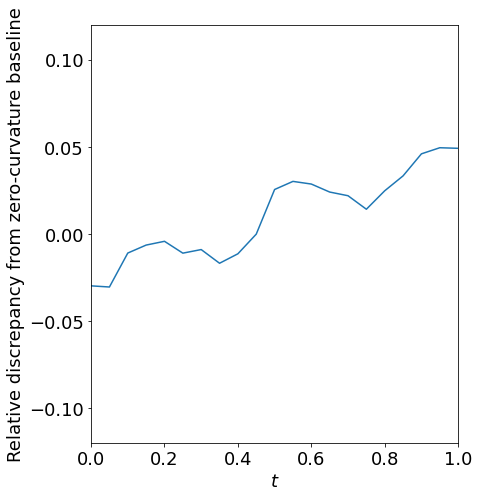

In [23]:
trmsd_T_r = torch.sqrt(torch.sum((log_p_barycentre_t_r - log_p_barycentre_t) ** 2,[1,2]) / protein_len)
trmsd_T_r_0 = torch.sqrt(torch.sum(log_p_barycentre_t ** 2,[1,2]) / protein_len)

fig_size = 21 # cm
plt.figure(figsize=(fig_size/3, fig_size/3))
plt.plot(T, (rmsd_T_r - trmsd_T_r)/trmsd_T_r_0)
plt.xlim([0,1])
plt.ylim([-0.12,0.12])
plt.xlabel(r'$t$')
plt.ylabel(r'Relative discrepancy from zero-curvature baseline')
# save figure
plt.savefig(os.path.join(results_folder,fig_prefix +f'_RMSD_and_TRMSD_progression_rank_{rank}'+formt))
plt.show